Hannen Naarany 324045335

Dorin Shteyman 206721102

<center>
<div>Machine Learning and Human Behavior - 236608 - Winter 2022-2023</div>
<h1>Homework #1 - Binary Choice 🐾</h1>
</center>



# Instructions and submission guidelines
The goal of this homework is to introduce you to google colab notebooks and simple binary choice models, and implement evaluation methods which will be used in the first workshop next week.

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Monday 14/11/2022, 23:59
* For any questions regarding this homework task, contact [Eden](mailto:edens@campus.technion.ac.il).


## Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm.auto import tqdm

# Task #1: numpy + pandas syntax warm-up

Goal of this task is to make sure you are familiar with basic numpy and pandas syntax. 



## numpy

Consider the following functions:

\begin{align}
f(x)
&=\begin{cases}
x & x \ge 0 \\
0 & x < 0
\end{cases}\\
g(x)
&=\begin{cases}
\sqrt{x} & x \ge 0 \\
-2(-x)^{\frac{1}{3}} & x < 0
\end{cases}
\end{align}

Implement $f(x)$, $g(x)$. Use numpy vectorized numpy calculations, and avoid using loops.

The functions should accept a numpy array `x` as an argument.

🔵 **Answer**:

In [26]:
def f(x):
    ## YOUR SOLUTION
    return np.maximum(0,x)

def g(x):
    ## YOUR SOLUTION
    return [-2*np.power(-y, 1/3) if y < 0 else np.sqrt(y) for y in x]

Plot $f(x)$ for $x\in[-1,1]$. Add a title for the plot, x/y labels, and a legend.

🔵 **Answer**:

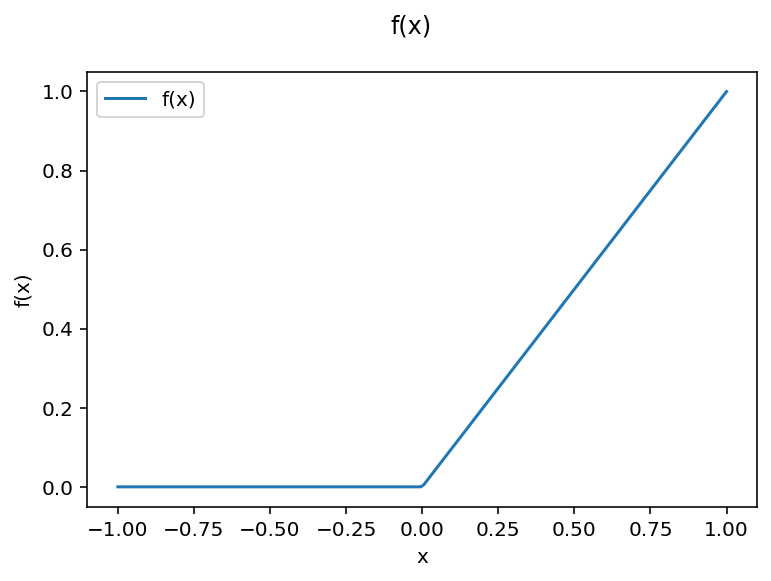

In [27]:
x = np.linspace(-1,1,200)
y1 = f(x)
# y2 = g(x)

fig,ax = plt.subplots()

## YOUR SOLUTION

ax.plot(x, y1, label='f(x)')
# ax.plot(x, y2, label='g(x)')
fig.suptitle('f(x)')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend();


## pandas

To get ourselves familiar with the syntax, we use the classic [iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset:

In [28]:
from sklearn.datasets import load_iris
iris_df = load_iris(as_frame=True)['data']
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


How many rows in `iris_df` have `sepal_length>=6`? 
Use vectorized calculations, and avoid using loops.

🔵 **Answer**:

In [29]:
## YOUR SOLUTION
print(iris_df[iris_df['sepal length (cm)']>=6].shape[0])

67


Plot a histogram of `sepal_width` with 20 bins:

🔵 **Answer**:

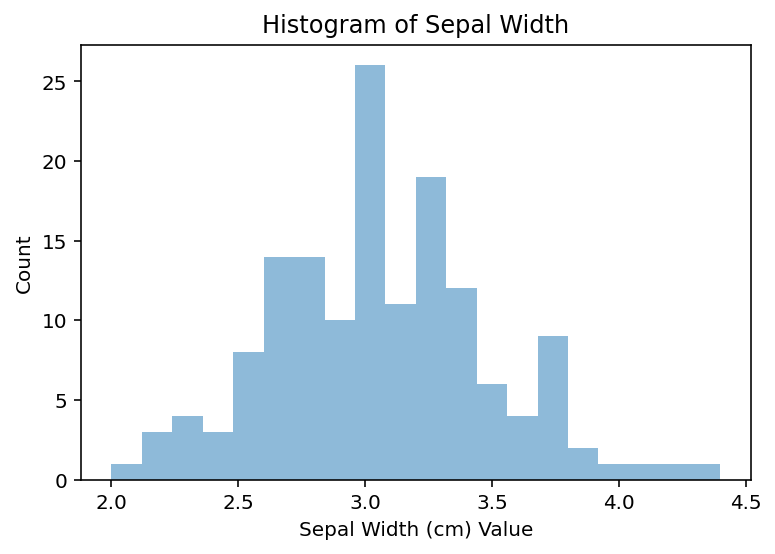

In [30]:
## YOUR SOLUTION
ax = iris_df['sepal width (cm)'].plot.hist(bins=20, alpha=0.5)
plt.title('Histogram of Sepal Width')
plt.xlabel('Sepal Width (cm) Value')
plt.ylabel('Count');

# Task \#2: Simple choice prediction


The goal of this task is to get you familiar with the object structure we will use in the workshops.

## Abstract population models 

For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

In [31]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    train_user_proportion = 0.6

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )
    
    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError
    
    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                for k in range(self.n_features):
                        dct[f'x_{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df
    
    def generate_train_eval_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )

    def get_feature_columns(self):
        return [
            f'x_{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value

## Introduction

We assume that decisions are made according to a latent inner product utility model. 

Specifically, we assume that each user $u$ is represented by a vector $u\in U \subseteq \mathbb{R}^d$, and each item $x$ is represented by a vector $x\in X \subseteq \mathbb{R}^d$. We assume that the true utility experienced by user $u$ from consuming item $x$ is defined as the inner product $v_u(x)=u^Tx$.

The `InnerProductTrueValueEnvironment` class provides a simple interface which will be useful for simulation. Here we inherit from it to implement a behvarioal model which simulates rational choice:

In [32]:
class RationalBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def _choice(self, users, items):
        """
        Simulate discrete choice. User choose i
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate the innner product to get the true value u.T@v. 
        # Result is a numpy array of shape (n_users, items_per_user)
        true_value = self._true_value(users, items)
        return {
            'true_value': true_value,
            'choice': true_value >= 0,
        }


As an example, here we instantiate an environment, and generate training and evaluation datasets with 1000 users. Note that the datasets are pandas DataFrames:

In [33]:
env = RationalBinaryChoiceEnvironment()
example_train_df, example_eval_df = env.generate_train_eval_datasets(n_users=1000)
example_train_df.head()

,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,true_value,choice
0,0,-1.417686,-2.600272,-0.177737,1.505136,-0.437995,0.950089,-0.998802,0.462857,-2.957555,False
1,0,0.541839,0.526848,-0.394655,-0.890864,-1.634388,-1.788274,0.400105,-1.769255,-4.870849,False
2,0,-1.188969,-1.401211,0.222495,1.578157,0.444534,1.486926,0.970476,-0.135781,1.525184,True
3,0,-0.603305,0.144808,0.367295,0.371610,1.671425,-0.612010,-0.530320,0.661940,1.608431,True
4,0,1.167322,-0.368487,-1.277399,-0.221364,1.012564,-0.391810,-0.769208,-1.347269,-1.877079,False


In the DataFrame above: The column `user_id` represents the user id, the columns `x_0`,...,`x_7` represent item features, the column `true_value` represents $v_u(x)$, and the column `choice` represent the actual choice (`choice==True` if $v_u(x)\ge 0$).

## Welfare

The *Welfare* associated with a predictor $f:X\to\{0,1\}$ and evaluation set $S\subseteq U \times X$ is defined according to the following formula:
$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$
where $f(x)\in\{0,1\}$ is the model prediction, and $v_u(x)$ is the true valuation of the item, as defined in the introduction above.

Implement the welfare function. 

The function should receive as input a prediction function `f` (e.g. `sklearn.linear_model.LogisticRegression.fit(...).predict`), an evaluation dataset (e.g as the evaluation set returned by `env.generate_train_eval_datasets(...)`), the name of the feature columns (e.g from `env.get_feature_columns()`), and the name of the column representing $v_u(x)$.

🔵 **Answer**:

In [34]:
def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set
    
    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.get_feature_columns()`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
  
    prod = f(eval_df[feature_columns]) @ eval_df[value_column]
    welfare = (np.sum(prod)) / (len(eval_df))

    return welfare

## Simulation exercise

In this exercise, we will examine the change in classification accuracy as a function of dataset size.

For each dataset size in `n_users_vec` ($\{3,6,\dots,48\}$):
* Generate training/evaluation datasets with the given amount of users (`n_users`). 
* Use the training set to train two models: A Logistic Regression and a Random Forest. Both models should use the `choice` column as a binary label for training. 
  (Hint: Given a training dataframe `train_df`  generated by environment `env`, the command `train_df[env.get_feature_columns()]` returns a dataframe with features as columns).
* Evaluate the accuracy and welfare of each model in predicting choice of the evaluation set.


To reduce randomization noise, repeat the experiment 10 times for each dataset size, and average the results.

🔵 **Answer**:

In [35]:
import sklearn.linear_model
import sklearn.ensemble

n_repetitions = 10
n_users_vec = np.arange(3,50,5)
models = {
    'logistic_regression': sklearn.linear_model.LogisticRegression,
    'random_forest': sklearn.ensemble.RandomForestClassifier,
}


# ## YOUR SOLUTION
models_accuracies = dict((key, dict((key_users, None) for key_users in n_users_vec)) for key in models.keys())
models_welfares = dict((key, dict((key_users, None) for key_users in n_users_vec)) for key in models.keys())

for model_name , model in models.items():
  for n_users in n_users_vec:
    accuracy_all_reps = 0
    welfare_all_reps = 0
    for i in range(n_repetitions):

      train_df, eval_df = env.generate_train_eval_datasets(n_users=n_users)
      x_train = train_df[env.get_feature_columns()]
      y_train = train_df['choice']
      # fit the current model to create a predict function
      pred_func = model().fit(x_train, y_train)

      x_val = eval_df[env.get_feature_columns()]
      y_val = eval_df['choice']

      #evaluate the model's accuracy 
      temp_accuracy = pred_func.score(x_val, y_val)
      accuracy_all_reps += temp_accuracy

      #evaluate the model's welfare
      temp_welfare = welfare(pred_func.predict, eval_df, env.get_feature_columns(), 'true_value')
      welfare_all_reps += temp_welfare
    # calculate final average score for the current number of users
    models_accuracies[model_name][n_users] = accuracy_all_reps / n_repetitions
    models_welfares[model_name][n_users] = welfare_all_reps / n_repetitions


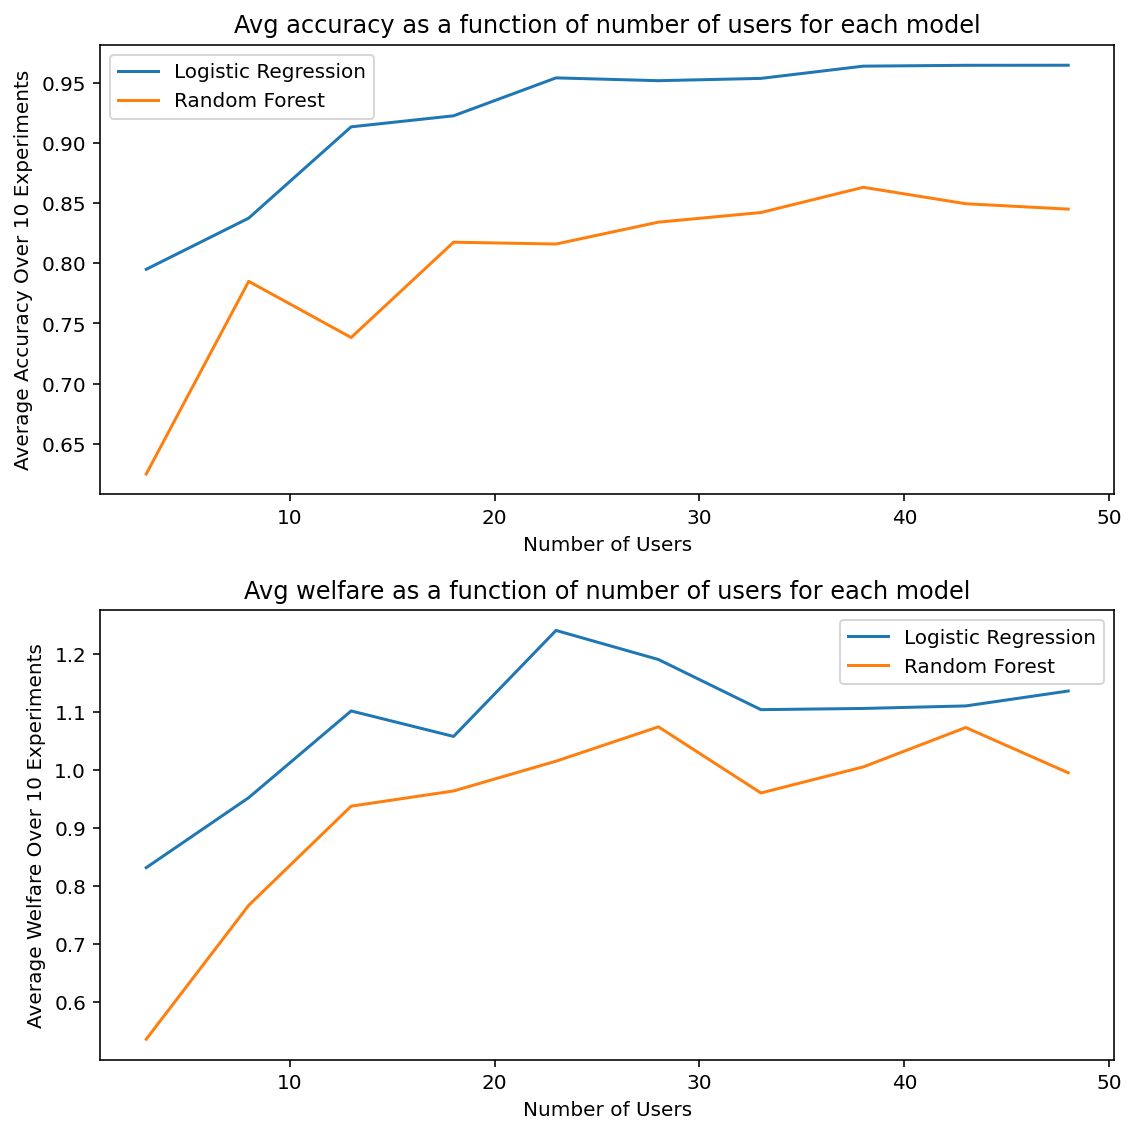

In [36]:
fig, ax = plt.subplots(2,1, figsize= (8,8))
ax[0].plot(n_users_vec, list(models_accuracies['logistic_regression'].values()), label='Logistic Regression')
ax[0].plot(n_users_vec, list(models_accuracies['random_forest'].values()), label='Random Forest')
ax[0].set_title('Avg accuracy as a function of number of users for each model')
ax[0].set_xlabel('Number of Users')
ax[0].set_ylabel('Average Accuracy Over 10 Experiments')
ax[0].legend();

ax[1].plot(n_users_vec, list(models_welfares['logistic_regression'].values()), label='Logistic Regression')
ax[1].plot(n_users_vec, list(models_welfares['random_forest'].values()), label='Random Forest')
ax[1].set_title('Avg welfare as a function of number of users for each model')
ax[1].set_xlabel('Number of Users')
ax[1].set_ylabel('Average Welfare Over 10 Experiments')
ax[1].legend();

fig.tight_layout()



Explain the results. What do you see in the graphs? Why do you think the graphs look like this? 

🔵 **Answer**:

(YOUR SOLUTION)

**comparing the models:** as we can clearly see, the logistic regression model outperforms the random forest model by both accuracy and welfare. this is due to the fact that the true value is an inner product of user with product, so it is expected that a logistic regression model well do better than a random forest, since linear regression models assume a linear score function and minimize the CE loss of the sigmoid of the linear score function.  

**comparing the number of users:** this graph demonstrates the trend that the more users (==samples) we obtain, the better our accuracy becomes. In addition, we see the largest improvement (for both models) between 3 and 8 users. in both models as well we see from that point on (+8 users) a trend of accuracy improvement, but more moderate (neglecting some small "bumps"). In general, we start to improve significantly less after 13 users in the logistic regression model and after 18 users in the random forest model. This means that if an optimization and efficiency are required, we can consider these thresholds for both models to be a sufficient amount of samples to get a good enough accuracy compared to each of the models' best accuracy performance.

Note - having not too many samples but just enough can also help with the generalization abilities of the model.